# osmnx-matplotlib-animation

In [8]:
import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## 1. Load the data

In [9]:
city = gpd.read_file('data/city.json')
city.crs = "EPSG:4326"
graph = ox.load_graphml("data/graph.graphml") # street network
districts = gpd.read_file('data/districts.json') # district shapefiles
districts.crs = "EPSG:4326"
hospitals = gpd.read_file('data/hospitals.json') # hospital locations
hospitals.crs = "EPSG:4326"

## 2. Find routes

In [10]:
# Specify origin points as hospital locations
orig_points = []
for geometry in hospitals["geometry"]:
    x, y = geometry.xy
    x = x[0]
    y = y[0]
    orig_points.append((y, x))
print(f'Number of origin points : {len(orig_points)}')

Number of origin points : 5


In [11]:
# Select a random district a destination point
n = 27
centroid = districts.iloc[n, :]['geometry'].centroid
district_name = districts.iloc[n, :]['WK_NAAM']
district = districts[districts['WK_NAAM'] == district_name]
print(f'Destination point : {district_name}')

Destination point : Wijk 28 Centrum


In [12]:
# Specify destination points
x, y = centroid.xy
x = x[0]
y = y[0]
dest_points = [(y, x)] * len(orig_points)

In [13]:
# Find nearest nodes to of specified origin desination points
# Based on them make the routes
orig_nodes = []
for orig_point in orig_points:
    orig_nodes.append(ox.get_nearest_node(graph, orig_point))
    
dest_nodes = []
for dest_point in dest_points:
    dest_nodes.append(ox.get_nearest_node(graph, dest_point))

In [14]:
%%time
egs = []
for orig_node in orig_nodes:
    egs.append(nx.ego_graph(graph, orig_node, radius=2000, distance='length'))

Wall time: 182 ms


In [15]:
routes = []
lengths = []
for orig_node, dest_node in zip(orig_nodes, dest_nodes):
    try:
        routes.append(nx.shortest_path(graph, source=orig_node, target=dest_node, weight='length'))
        length = nx.shortest_path_length(G=graph, source=orig_node, target=dest_node, weight='length')
        lengths.append(length)
        print(f'Route length : {round(length / 1000, 1)} km')
    except:
        print('Error. No route from {} to {}.'.format(orig_node, dest_node))
        pass

print()
print(f'The shortest route is {round(min(lengths) / 1000, 1)} km')

Route length : 4.8 km
Route length : 4.0 km
Route length : 1.1 km
Route length : 4.8 km
Route length : 4.0 km

The shortest route is 1.1 km


## 3. Define route coordinates

In [16]:
# Project graph to 3395 to make CRS coherent with the rest of the objects
projected_graph = ox.project_graph(graph, to_crs="EPSG:3395")

In [17]:
# Extrat coordinates of route nodes 
route_coorindates = []

for route in routes:
    points = []
    for node_id in route:
        x = projected_graph.nodes[node_id]['x']
        y = projected_graph.nodes[node_id]['y']
        points.append([x, y])
    route_coorindates.append(points)
    
n_routes = len(route_coorindates)
max_route_len = max([len(x) for x in route_coorindates])

In [18]:
print(f'Number of routes : {n_routes}')
print(f'Number of nodes in the first route : {len(route_coorindates[0])}')
print(f'Coordinates of the first node in the first route : {route_coorindates[0][0]}')
print(f'Max number of nodes in a route : {max_route_len}')

Number of routes : 5
Number of nodes in the first route : 62
Coordinates of the first node in the first route : [474767.45363185334, 6776344.155987251]
Max number of nodes in a route : 62


## 4. Animate ambulance cars

In [19]:
%%time
# Transform everything to the same coordiante system 
# Figures plotted with 3395 looks better than 4326 :-)
city.to_crs('EPSG:3395', inplace=True)
district = district.to_crs('EPSG:3395')
hospitals.to_crs('EPSG:3395', inplace=True)

Wall time: 257 ms


In [20]:
# Fix bounds for axis
x_min, y_min, x_max, y_max = city.total_bounds

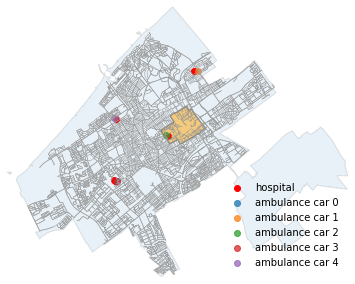

In [21]:
# Prepare the layout
fig, ax = ox.plot_graph(projected_graph, node_size=0, edge_linewidth=0.5, show=False, close=False) # network
city.plot(ax=ax, edgecolor='black', linewidth=1, alpha=0.1) # city shapefile
district.plot(ax=ax, edgecolor='black', linewidth=1, alpha=0.5, color='orange') # destination district
hospitals.plot(ax=ax, color='red', label='hospital') # hospitals
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max)) # set the map limits

# Each list is a route
# Length of this list = n_routes
scatter_list = []

# Plot the first scatter plot (starting nodes = initial car locations = hospital locations)
for j in range(n_routes):
    scatter_list.append(ax.scatter(route_coorindates[j][0][0], # x coordiante of the first node of the j route
                                   route_coorindates[j][0][1], # y coordiante of the first node of the j route
                                   label=f'ambulance car {j}', 
                                   alpha=.75))
    
plt.legend(frameon=False)

def animate(i):
    """Animate scatter plot (car movement)
    
    Args:
        i (int) : Iterable argument. 
    
    Returns:
        None
        
    """
    # Iterate over all routes = number of ambulance cars riding
    for j in range(n_routes):
        # Some routes are shorter than others
        # Therefore we need to use try except with continue construction
        try:
            # Try to plot a scatter plot
            x_j = route_coorindates[j][i][0]
            y_j = route_coorindates[j][i][1]
            scatter_list[j].set_offsets(np.c_[x_j, y_j])
        except:
            # If i became > len(current_route) then continue to the next route
            continue

# Make the animation
animation = FuncAnimation(fig, animate, frames=max_route_len)

# HTML(animation.to_jshtml()) # to display animation in Jupyter Notebook
animation.save('animation.mp4', dpi=300) # to save animation